# University of Applied Sciences Munich
## Kalman Filter Tutorial

---
(c) Lukas Köstler (lkskstlr@gmail.com)

## Physics
I use a basketball throw straight into the air with drag [1], [2]:

\begin{equation}
\ddot{x} = - g - \lambda \, \dot{x} \, \vert \dot{x} \vert
\end{equation}
with

\begin{align}
\text{time:} && t && s \\
\text{height:} && x = x(t) && m \\
\text{gravitational acc.:} && g = 9.81 && \frac{m}{s^2} \\
\text{lambda:} && \lambda = \frac{C_d \rho A}{2 m_{ball}} = \frac{0.54 \cdot 1.18 \cdot 0.75^2}{4  \pi \cdot 2 \cdot 0.6} \approx 0.024 && \frac{kg \,m^2}{m^3 \,kg} = \frac{1}{m} \\
\text{drag coefficient:} && C_d = 0.54 && 1 \\
\text{density (air)} && \rho = 1.18 && \frac{kg}{m^3} \\
\text{crossectional area} && A = \frac{0.75^2}{4 \pi} && m^2 \\
\text{mass ball} && m_{ball} = 0.6 && kg
\end{align}

So
\begin{equation}
\ddot{x} \approx - 9.81 - 0.024 \, \dot{x} \, \vert \dot{x} \vert
\end{equation}




[1]: http://www.uphysicsc.com/2011-GM-B-379.PDF
[2]: https://en.wikipedia.org/wiki/Drag_(physics)

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 3)

import numpy as np
from scipy.integrate import quad
%matplotlib notebook

#### Sources
+ http://www.uphysicsc.com/2011-GM-B-379.PDF

In [2]:
# Constants and ODE solution
v0 = 120.0 / 3.6 # initial velocity upwards
_lambda = 0.54*1.18*0.75**2 / (4*np.pi*2*0.6) # coefficient
g = 9.81 # gravitational acceleration

# Upwards velocity
def v_t_up(t):
    return - np.sqrt(g / _lambda) * np.tan(np.sqrt(g*_lambda)*t - np.arctan(np.sqrt(_lambda/g)*v0))

# Downwards velocity
def v_t_down(t):
    return - np.sqrt(g / _lambda) * np.tanh(np.sqrt(g*_lambda)*t)
# Downwards delta x (sign omitted, i.e. > 0)
def delta_x_t_down(t):
    return 1.0 / _lambda * np.log(np.cosh(np.sqrt(g*_lambda)*t))


# Point of zero velocity (upwards -> downwards)
t1 = np.arctan(np.sqrt(_lambda/g)*v0) / np.sqrt(g*_lambda)
# Height at point of return
h1, error_h1 = quad(lambda t: v_t_up(t), 0, t1)
# Time for downwards movement
dt2 = np.arccosh(np.exp(h1*_lambda)) / np.sqrt(g*_lambda)

In [3]:
# Generate data
dt = 0.1 # sampling rate
T = t1+dt2
N = int(np.ceil(T/dt))

fac = 7

tt = np.array(range(N+1))*dt
tt_h = np.array(range(fac*N+1))*dt/fac

xx = np.zeros_like(tt)
xx_h = np.zeros_like(tt_h)

vv = np.zeros_like(tt)
vv_h = np.zeros_like(tt_h)

# first
vv_h[0] = v_t_up(0.0)


h1_num = np.NAN
for k in range(1, len(tt_h)):
    if tt_h[k] < t1:
        _dx, _e = quad(v_t_up, tt_h[k-1], tt_h[k])
        
        xx_h[k] = xx_h[k-1] + _dx
        vv_h[k] = v_t_up(tt_h[k])
    elif tt_h[k-1] <= t1 <= tt_h[k]:        
        _dx1, _e1 = quad(v_t_up, tt_h[k-1], t1)
        
        h1_num = xx_h[k-1] + _dx1
        
        xx_h[k] = h1_num - delta_x_t_down(tt_h[k]-t1)
        vv_h[k] = v_t_down(tt_h[k]-t1)
        
    elif t1 < tt_h[k]:
        xx_h[k] = h1_num - delta_x_t_down(tt_h[k]-t1)
        vv_h[k] = v_t_down(tt_h[k]-t1)
    else:
        print("ERROR")

In [4]:
# Subsample
ind = range(0, fac*N+1, fac)

tt = tt_h[ind]
xx = xx_h[ind]
vv = vv_h[ind]

In [40]:
# Noise
np.random.seed(0)

sigma_v_base = 1.0
sigma_v_range = 0.2

sigma_x_base = 1.5
sigma_x_range = 0.02

sigmas_v = sigma_v_base + sigma_v_range * np.abs(vv)
sigmas_x = sigma_x_base + sigma_x_range * np.abs(xx)

xx_n = xx + np.random.randn(len(xx))*sigmas_x
vv_n = vv + np.random.randn(len(vv))*sigmas_v

xx_n[11] = xx[11] + 15.126734
xx_n[40] = xx[40] + 15.156423

np.savetxt('time.csv', tt)
np.savetxt('measurements.csv', xx_n)
np.savetxt('velocity.csv', vv_n)
np.savetxt('groundtruth.csv', xx)

<IPython.core.display.Javascript object>


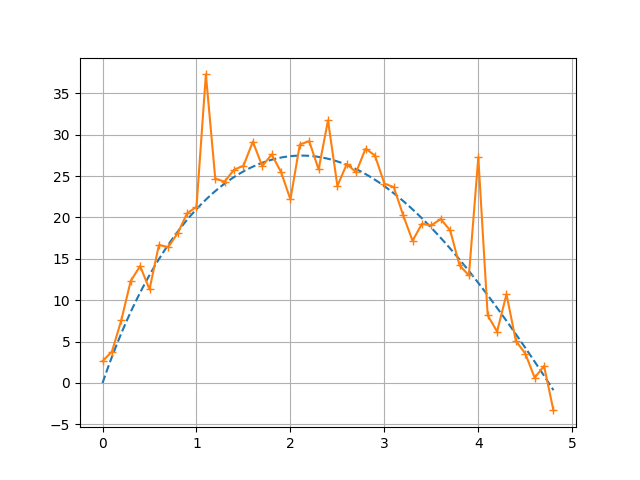

In [6]:
# Plot
plt.figure()
plt.plot(tt_h, xx_h, '--')
plt.plot(tt, xx_n, '+-')
plt.grid('on')
plt.show()

<IPython.core.display.Javascript object>


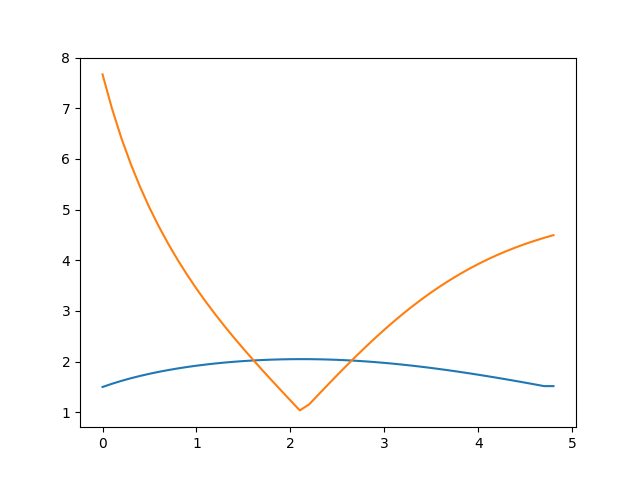

In [7]:
plt.figure()
plt.plot(tt, sigmas_x, label="$\sigma_x$")
plt.plot(tt, sigmas_v, label="$\sigma_v$")
plt.show()

<IPython.core.display.Javascript object>


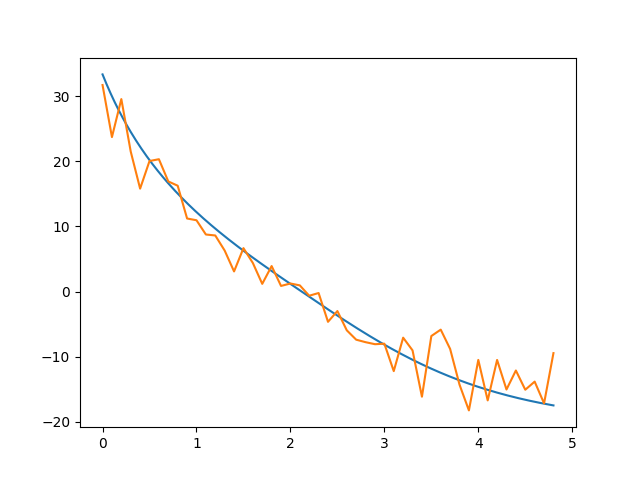

In [8]:
plt.figure()
plt.plot(tt_h, vv_h, tt, vv_n)
plt.show()

<IPython.core.display.Javascript object>


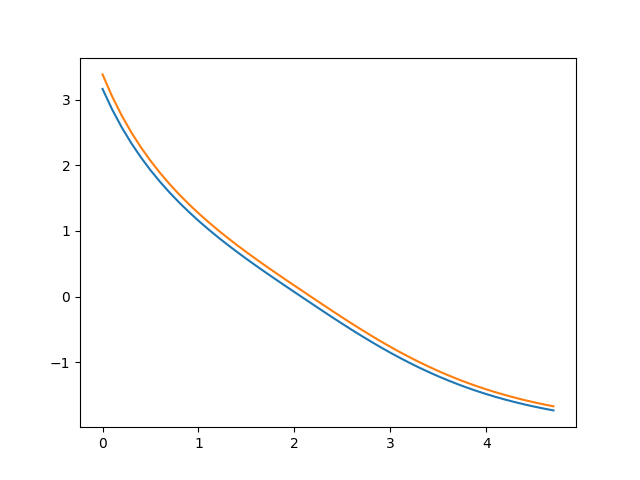

In [28]:
plt.figure()
plt.plot(tt[0:-1], np.diff(xx), tt[0:-1], vv[0:-1]*dt + 0.5*g*dt**2)

<IPython.core.display.Javascript object>


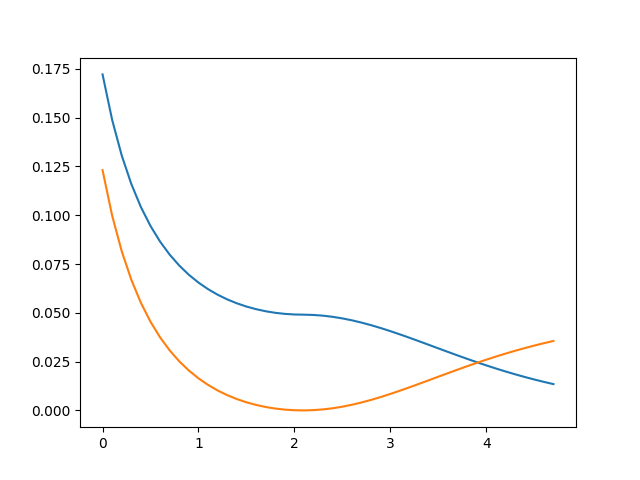

In [35]:
plt.figure()
plt.plot(tt[0:-1], np.abs(vv[0:-1]*dt-np.diff(xx)), label="no quad approx")
plt.plot(tt[0:-1], np.abs(vv[0:-1]*dt-0.5*g*dt**2-np.diff(xx)), label="quad approx")

<IPython.core.display.Javascript object>


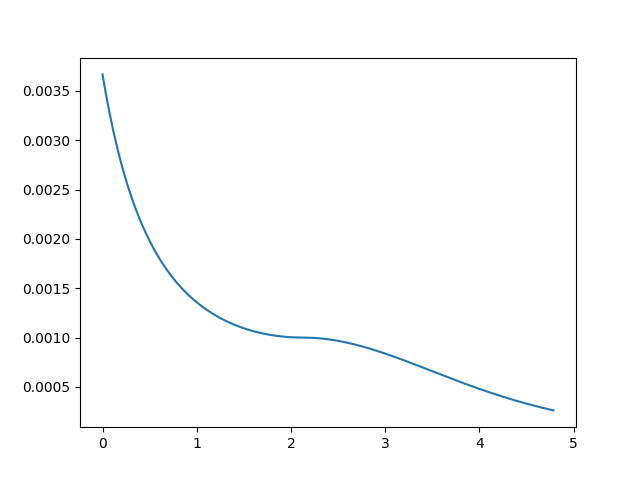

In [17]:
plt.figure()
plt.plot(tt_h[0:-1], vv_h[0:-1]*(dt/fac)-np.diff(xx_h))

In [33]:
np.sqrt( np.mean( (vv[0:-1]*dt-np.diff(xx))**2 ) )

0.063363947970518447

In [41]:
np.

array([  0.        ,   3.16120312,   6.00982966,   8.58559556,
        10.9200373 ,  13.0385682 ,  14.96192158,  16.70718745,
        18.28857234,  19.7179658 ,  21.00536944,  22.15922588,
        23.18667382,  24.09374765,  24.88553454,  25.56629884,
        26.13958045,  26.60827258,  26.97468256,  27.24057867,
        27.40722489,  27.47540528,  27.4454549 ,  27.31759055,
        27.09240496,  26.77093319,  26.35463385,  25.84536308,
        25.24534223,  24.55712059,  23.78353419,  22.92766225,
        21.99278236,  20.98232583,  19.89983412,  18.74891739,
        17.53321593,  16.25636497,  14.92196332,  13.53354602,
        12.09456104,  10.60834996,   9.07813253,   7.50699473,
         5.89788016,   4.2535843 ,   2.57675137,   0.86987341,  -0.86470875])